## Data quality check / cleaning / preparation 

In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# CV
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score,train_test_split,RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import GridSearchCV, ParameterGrid
import time as time

# Models
from sklearn.linear_model import LogisticRegression
from patsy import dmatrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from catboost import CatBoostClassifier

OnlineNewsPopularity = pd.read_csv("OnlineNewsPopularity.csv")

In [3]:
clean = OnlineNewsPopularity.drop(['url'], axis = 1)

### Distribution of response
*By Daniel He*

<AxesSubplot:xlabel=' shares', ylabel='Density'>

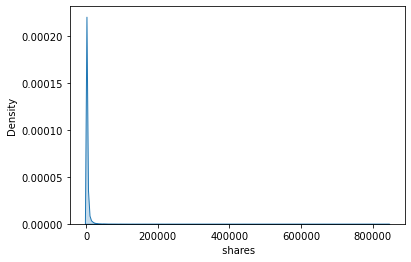

In [120]:
# Heavily skewed initially, through less skewed after our tranformation later
response_clean = clean[' shares']
sns.kdeplot(response_clean, fill=True, bw_method = .1)

### Data cleaning
*By Sarah Hsu*

In [4]:
data = OnlineNewsPopularity.rename(columns={'url': 'url', ' timedelta': 'timedelta', ' n_tokens_title': "n_tokens_title", ' n_tokens_content': 'n_tokens_content',
       ' n_unique_tokens': 'n_unique_tokens', ' n_non_stop_words': 'n_non_stop_words', ' n_non_stop_unique_tokens': 'n_non_stop_unique_tokens',
       ' num_hrefs': 'num_hrefs', ' num_self_hrefs': 'num_self_hrefs', ' num_imgs': 'num_imgs', ' num_videos': 'num_videos',
       ' average_token_length': 'average_token_length', ' num_keywords': 'num_keywords', ' data_channel_is_lifestyle': 'data_channel_is_lifestyle',
       ' data_channel_is_entertainment': 'data_channel_is_entertainment', ' data_channel_is_bus': 'data_channel_is_bus',
       ' data_channel_is_socmed': 'data_channel_is_socmed', ' data_channel_is_tech': 'data_channel_is_tech',
       ' data_channel_is_world': 'data_channel_is_world', ' kw_min_min': 'kw_min_min', ' kw_max_min': 'kw_max_min', ' kw_avg_min': 'kw_avg_min',
       ' kw_min_max': 'kw_min_max', ' kw_max_max': 'kw_max_max', ' kw_avg_max': 'kw_avg_max', ' kw_min_avg': 'kw_min_avg',
       ' kw_max_avg': 'kw_max_avg', ' kw_avg_avg': 'kw_avg_avg', ' self_reference_min_shares': 'self_reference_min_shares',
       ' self_reference_max_shares': 'self_reference_max_shares', ' self_reference_avg_sharess': 'self_reference_avg_sharess',
       ' weekday_is_monday': 'weekday_is_monday', ' weekday_is_tuesday': 'weekday_is_tuesday', ' weekday_is_wednesday': 'weekday_is_wednesday',
       ' weekday_is_thursday': 'weekday_is_thursday', ' weekday_is_friday': 'weekday_is_friday', ' weekday_is_saturday': 'weekday_is_saturday',
       ' weekday_is_sunday': 'weekday_is_sunday', ' is_weekend': 'is_weekend', ' LDA_00': 'LDA_00', ' LDA_01': 'LDA_01', ' LDA_02': 'LDA_02',
       ' LDA_03': 'LDA_03', ' LDA_04': 'LDA_04', ' global_subjectivity': 'global_subjectivity',
       ' global_sentiment_polarity': 'global_sentiment_polarity', ' global_rate_positive_words': 'global_rate_positive_words',
       ' global_rate_negative_words': 'global_rate_negative_words', ' rate_positive_words' : 'rate_positive_words',
       ' rate_negative_words': 'rate_negative_words', ' avg_positive_polarity': 'avg_positive_polarity',
       ' min_positive_polarity': 'min_positive_polarity', ' max_positive_polarity': 'max_positive_polarity',
       ' avg_negative_polarity': 'avg_negative_polarity', ' min_negative_polarity': 'min_negative_polarity',
       ' max_negative_polarity': 'max_negative_polarity', ' title_subjectivity': 'title_subjectivity',
       ' title_sentiment_polarity': 'title_sentiment_polarity', ' abs_title_subjectivity': 'abs_title_subjectivity',
       ' abs_title_sentiment_polarity': 'abs_title_sentiment_polarity', ' shares': 'shares'})

In [5]:
# We observed from EDA that there was this one faulty value in a 0-1 range variable, with an observation in the 700s
# n_unique_tokens is an error
data.iloc[data.n_unique_tokens.argmax()]

url                             http://mashable.com/2014/08/18/ukraine-civilia...
timedelta                                                                   142.0
n_tokens_title                                                                9.0
n_tokens_content                                                           1570.0
n_unique_tokens                                                             701.0
                                                      ...                        
title_subjectivity                                                            0.0
title_sentiment_polarity                                                      0.0
abs_title_subjectivity                                                        0.0
abs_title_sentiment_polarity                                                  0.0
shares                                                                       5900
Name: 31037, Length: 61, dtype: object

In [6]:
# Also an error
data.iloc[31037].n_non_stop_words

1042.0

In [7]:
# Also an error
data.iloc[31037].n_non_stop_unique_tokens

650.0

In [8]:
# Transforming
data.iloc[31037, data.columns.get_loc('n_unique_tokens')] = data.n_unique_tokens[31037]/data.n_tokens_content[31037]
data.iloc[31037, data.columns.get_loc('n_non_stop_words')] = data.n_non_stop_words[31037]/data.n_tokens_content[31037]
data.iloc[31037, data.columns.get_loc('n_non_stop_unique_tokens')] = data.n_non_stop_unique_tokens[31037]/data.n_tokens_content[31037]

In [9]:
# Checking that observation again, and now it is fixed
data.iloc[31037]

url                             http://mashable.com/2014/08/18/ukraine-civilia...
timedelta                                                                   142.0
n_tokens_title                                                                9.0
n_tokens_content                                                           1570.0
n_unique_tokens                                                          0.446497
                                                      ...                        
title_subjectivity                                                            0.0
title_sentiment_polarity                                                      0.0
abs_title_subjectivity                                                        0.0
abs_title_sentiment_polarity                                                  0.0
shares                                                                       5900
Name: 31037, Length: 61, dtype: object

### Data preparation
*By Daniel He and Sarah Hsu*

The following data preparation steps helped us to prepare our data for implementing various modeling / validation techniques:

1. Since we need to predict house price, we derived some new predictors *(from existing predictors)* that intuitively seem to be helpuful to predict house price. 

2. We have created a standardized version of the dataset, as we will use it to develop Lasso / Ridge regression models.

#### Setting default classification threshold since it wasn't included in the original dataset

In [10]:
# Changing shares (our response variable) into a variable that doesn't increase overtime naturally by removing time element into average per day
data['avg_shares_per_day'] = data['shares']/data['timedelta']

In [11]:
np.median(data.avg_shares_per_day)

5.6131399928392405

In [12]:
data['popular'] = data.avg_shares_per_day.apply(lambda x: 1 if x > np.median(data.avg_shares_per_day)
                                    else 0)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['shares', 'url', 'popular', 'timedelta', 'avg_shares_per_day'], axis = 1),
    data['popular'],
    test_size = 0.2,
    random_state = 42)

In [14]:
# Standardizing the dataset with StandardScaler
from sklearn.preprocessing import StandardScaler

col_names = X_train.columns.tolist()

scaler = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns = col_names)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = col_names) # Do NOT refit the scaler with the test data, just transform it.

#### Feature selection

In [15]:
selection_1 = CatBoostClassifier(silent = True).fit(X_train, y_train)

In [16]:
feature_importances = pd.DataFrame(columns = ['Predictor', 'Importance'])
feature_importances['Predictor'] = X_train.columns
feature_importances['Importance'] = selection_1.feature_importances_
feature_importances.sort_values(by = 'Importance', ascending = False, inplace = True)

In [17]:
feature_importances

,Predictor,Importance
17,kw_min_min,19.999903
24,kw_max_avg,9.343322
19,kw_avg_min,3.423716
22,kw_avg_max,3.326570
25,kw_avg_avg,2.948959
18,kw_max_min,2.766082
26,self_reference_min_shares,2.570225
7,num_imgs,2.435495
38,LDA_01,2.341883
41,LDA_04,2.232416


In [18]:
feats = list(feature_importances[feature_importances.Importance >= np.quantile(feature_importances.Importance, 0.2)].Predictor)

In [19]:
data_dropped = pd.concat([data.loc[:, feats], data.popular], axis = 1)

## Exploratory data analysis
*By Daniel He*

In [20]:
cleaned = OnlineNewsPopularity.drop(['url'], axis = 1)

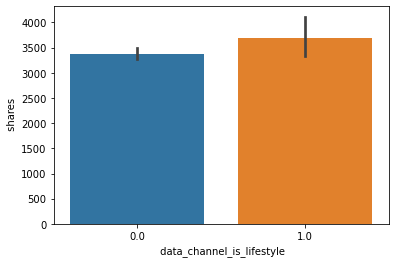

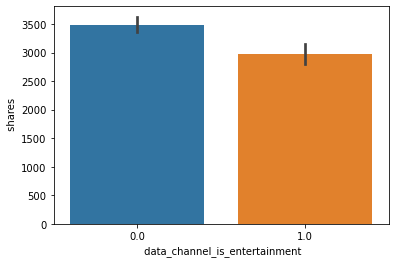

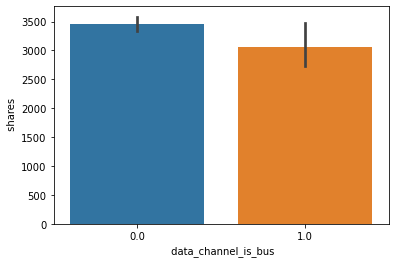

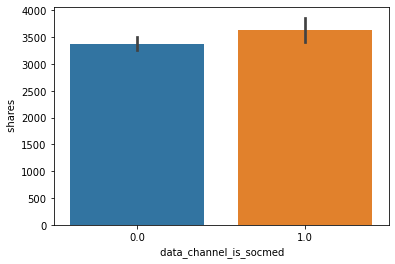

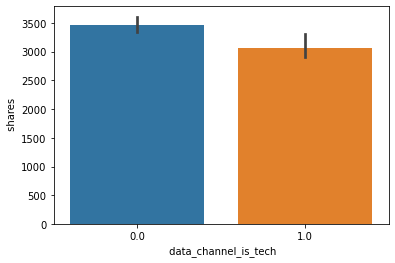

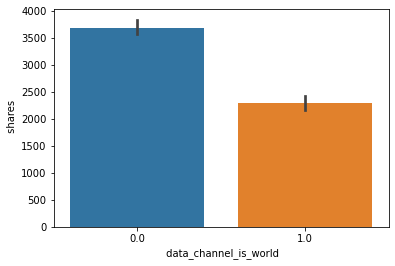

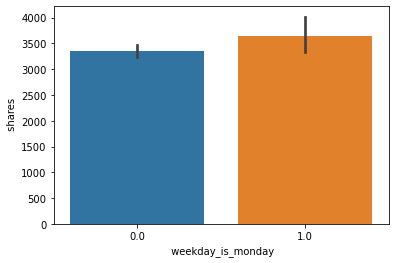

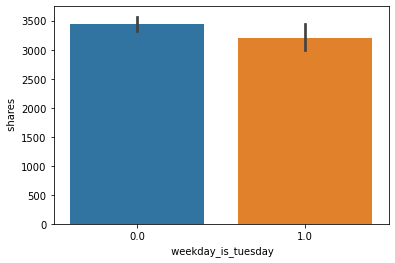

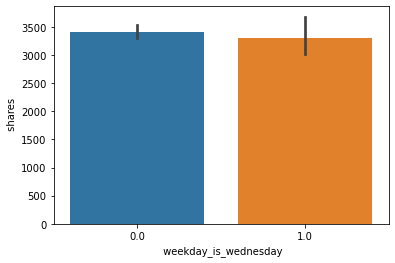

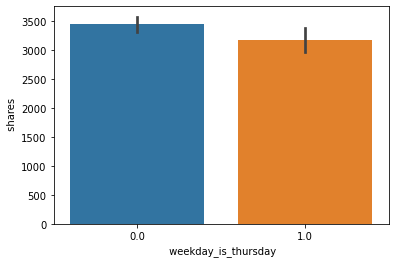

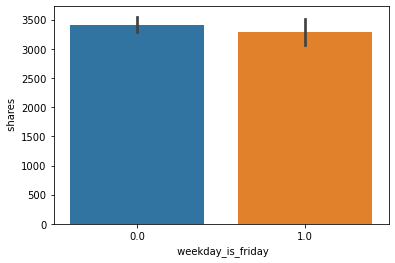

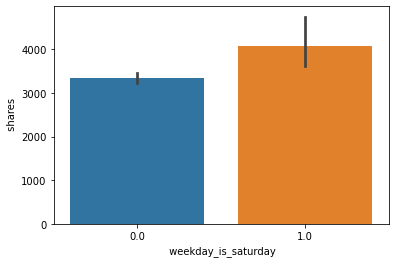

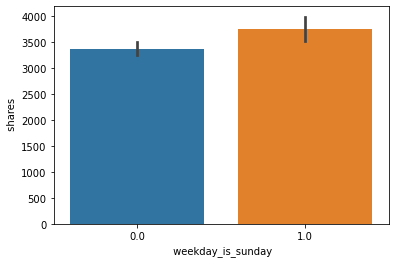

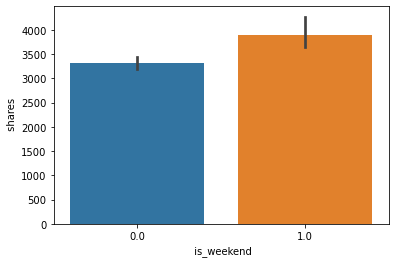

In [21]:
# Visualizing categorical variables (by Daniel He)
cleaned_cat = cleaned.loc[:, [' data_channel_is_lifestyle',
       ' data_channel_is_entertainment', ' data_channel_is_bus',
       ' data_channel_is_socmed', ' data_channel_is_tech',
       ' data_channel_is_world', ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday',
       ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday',
       ' weekday_is_sunday', ' is_weekend', ' shares']]

for x in cleaned_cat.columns:
    if x != ' shares':
        sns.barplot(x= x, y = ' shares', data = cleaned_cat)
        plt.show()

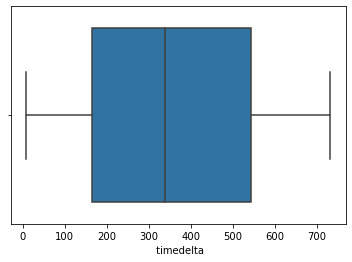

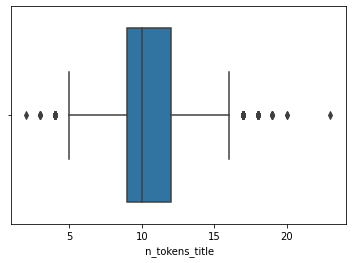

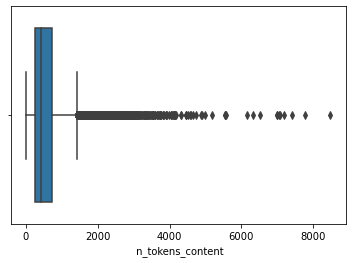

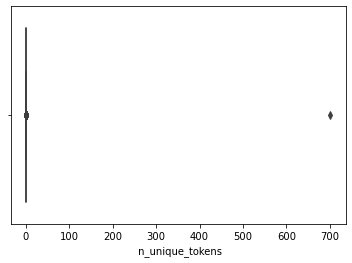

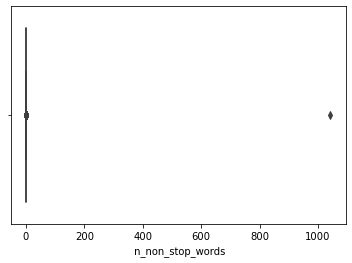

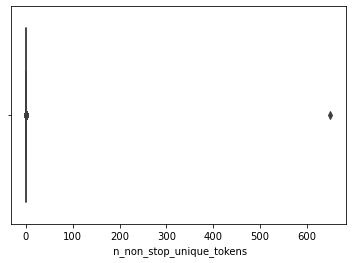

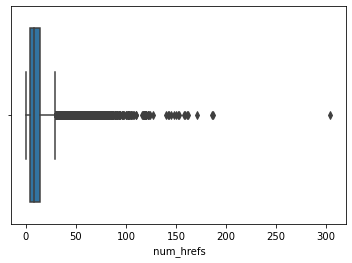

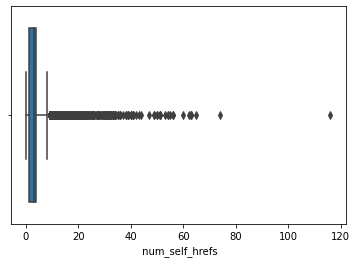

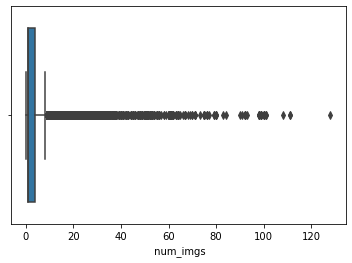

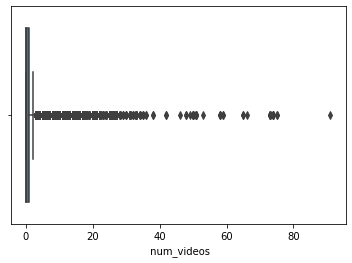

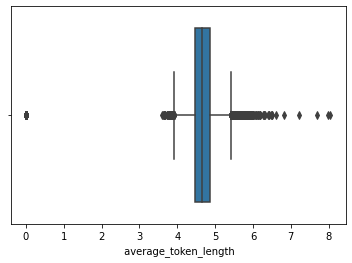

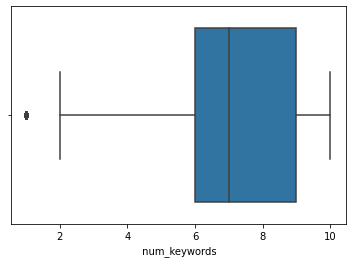

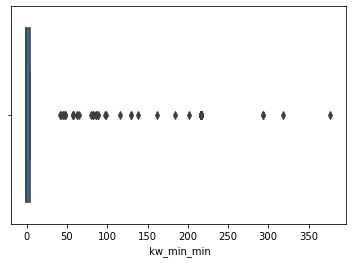

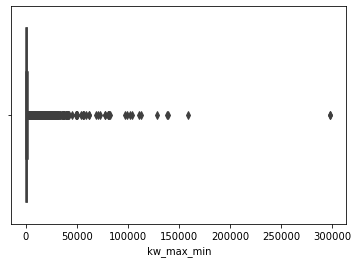

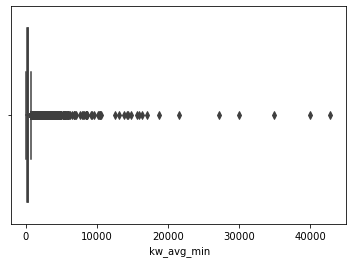

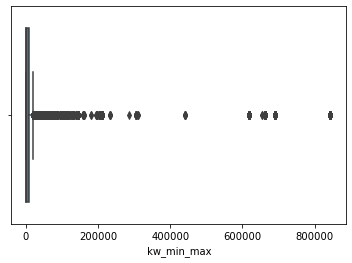

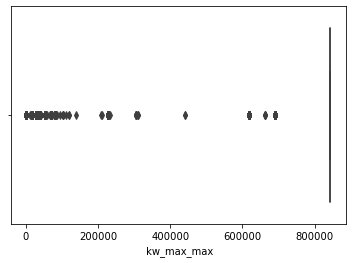

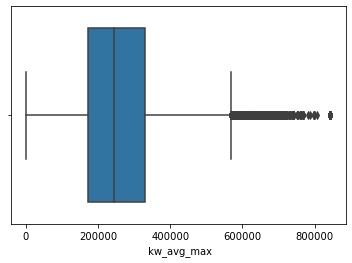

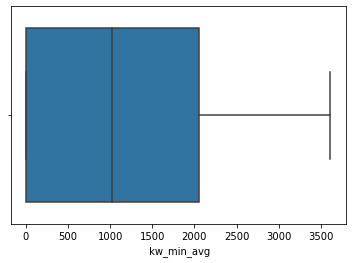

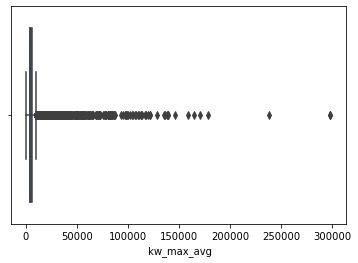

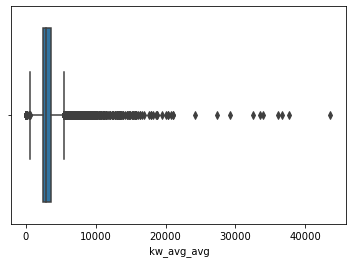

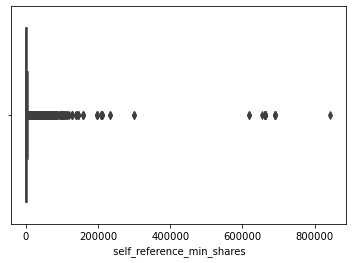

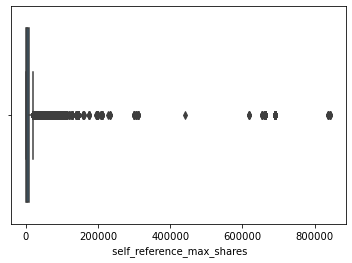

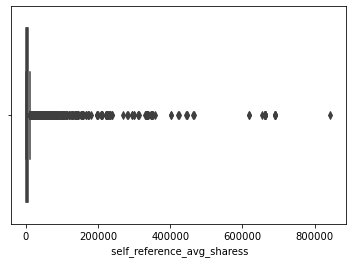

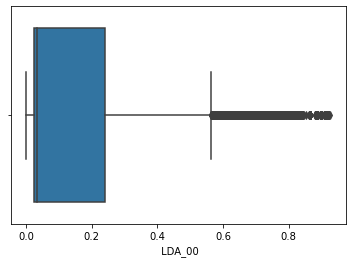

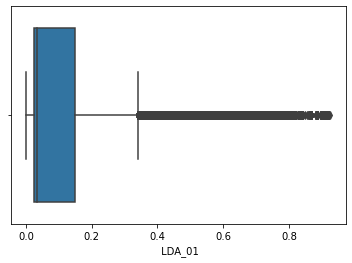

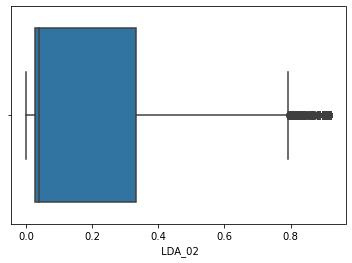

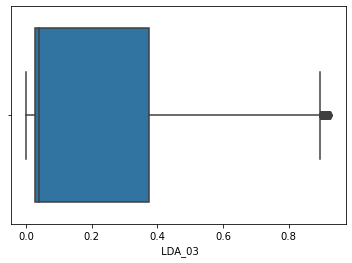

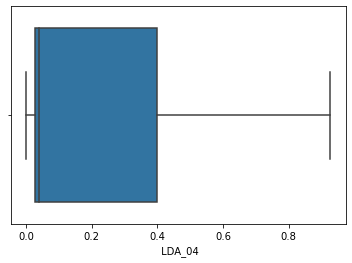

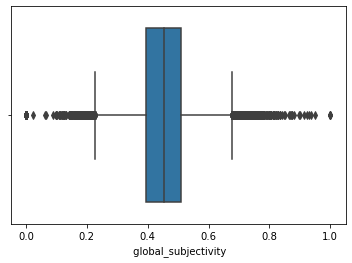

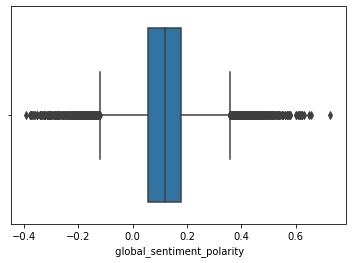

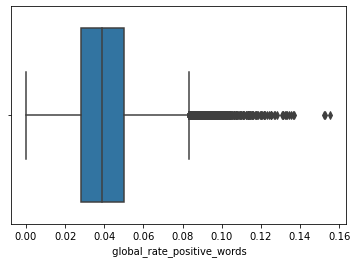

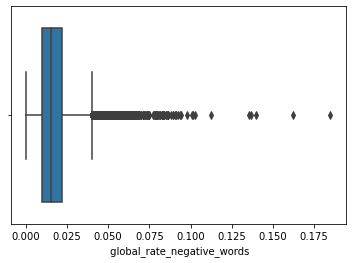

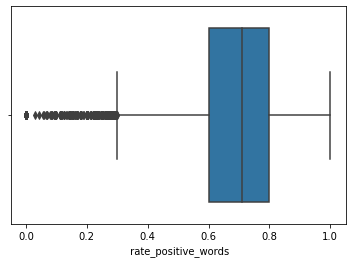

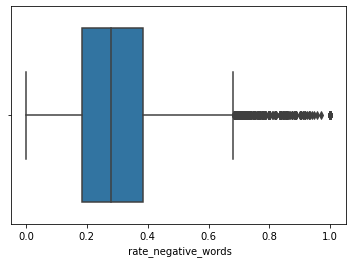

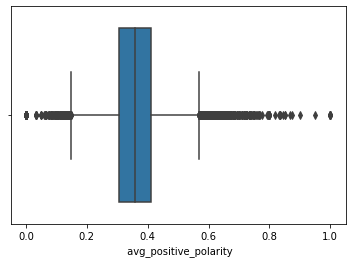

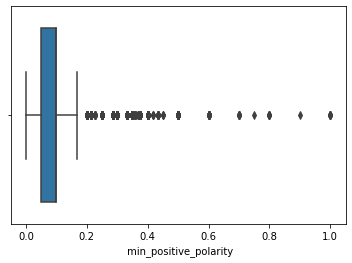

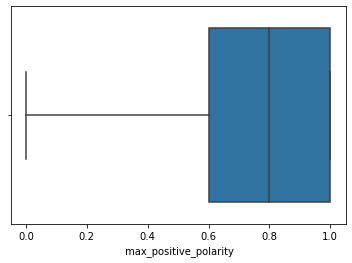

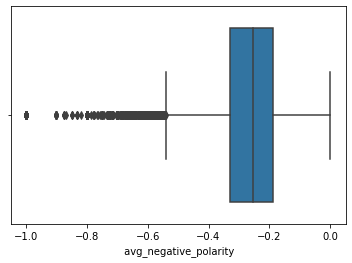

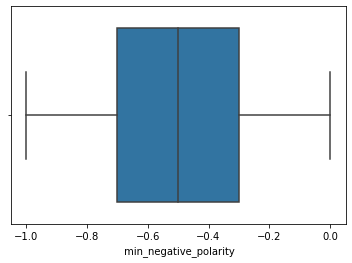

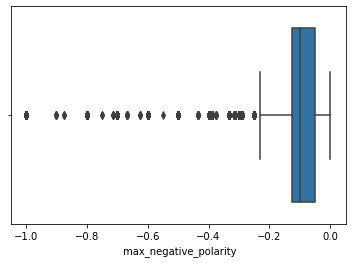

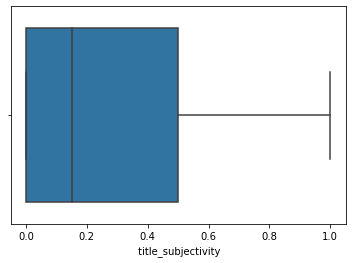

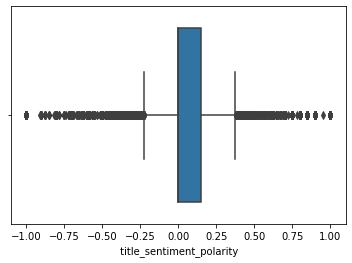

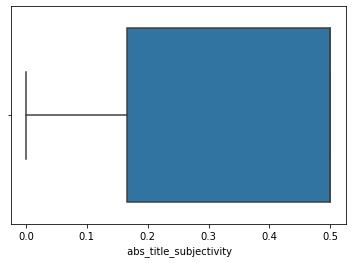

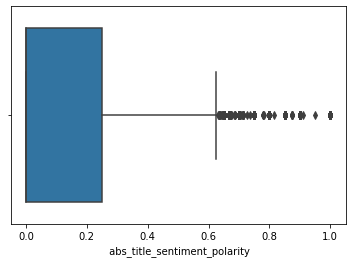

In [22]:
# Visualizing Continious variables (by Daniel He)
cleaned_con = cleaned.drop([' data_channel_is_lifestyle',
       ' data_channel_is_entertainment', ' data_channel_is_bus',
       ' data_channel_is_socmed', ' data_channel_is_tech',
       ' data_channel_is_world', ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday',
       ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday',
       ' weekday_is_sunday', ' is_weekend', ' shares'], axis=1)
for x in cleaned_con:
    sns.boxplot(x= cleaned_con[x])
    plt.show()

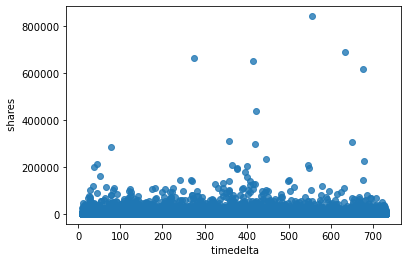

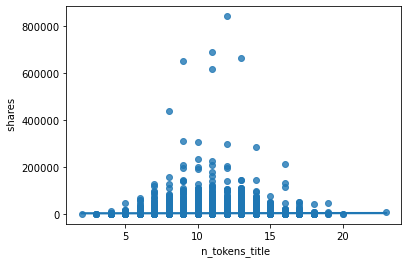

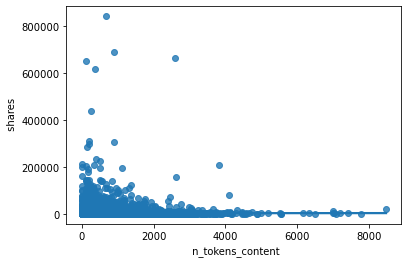

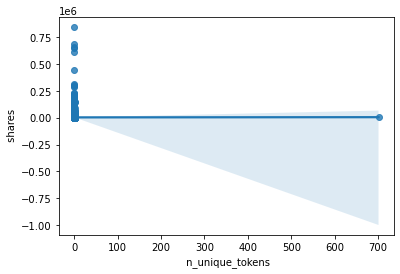

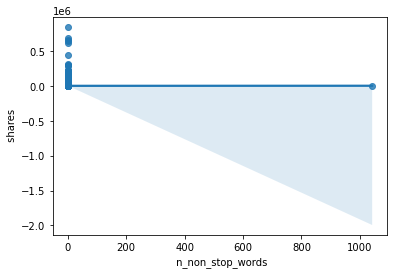

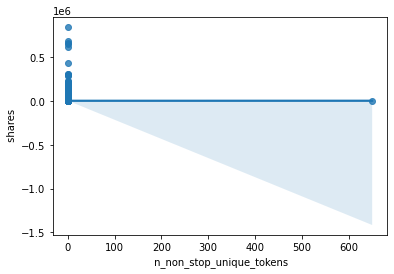

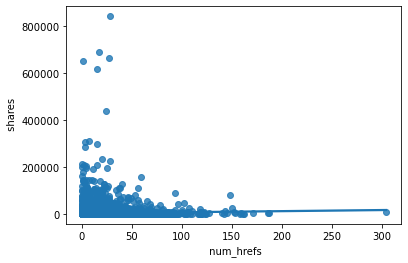

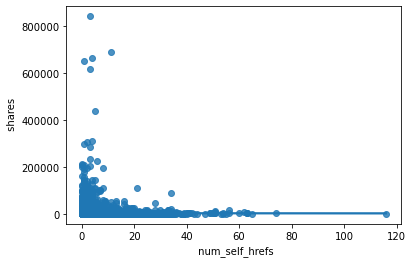

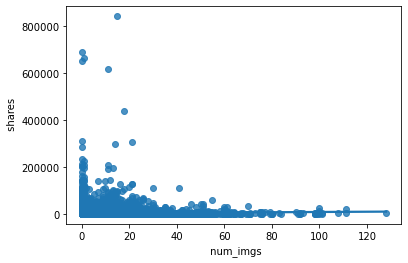

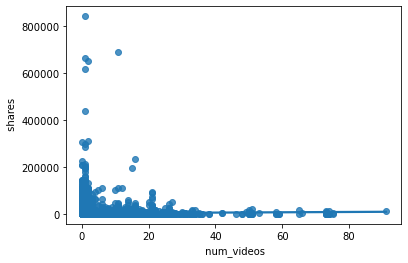

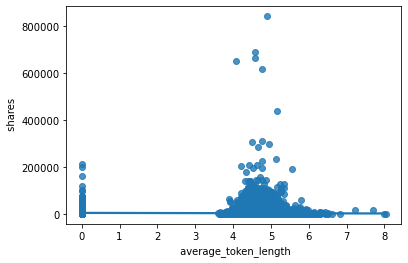

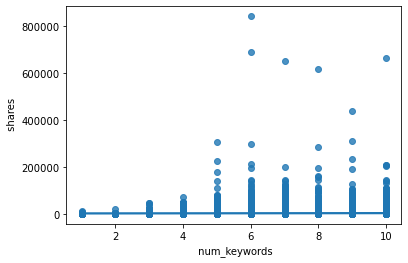

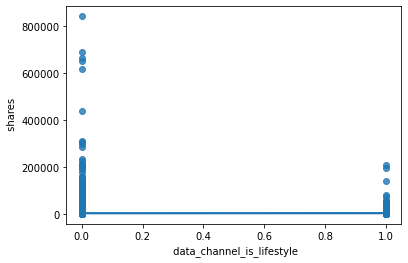

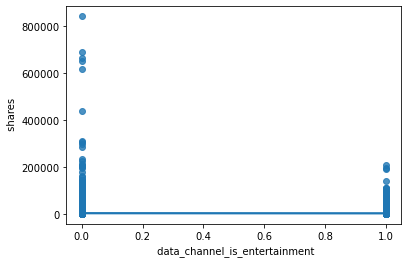

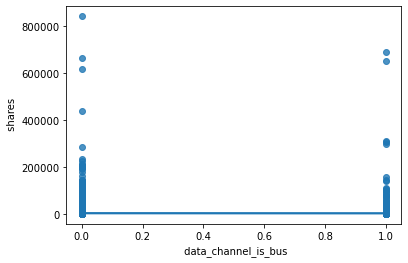

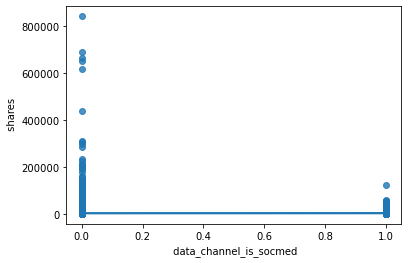

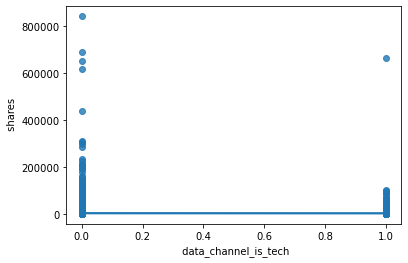

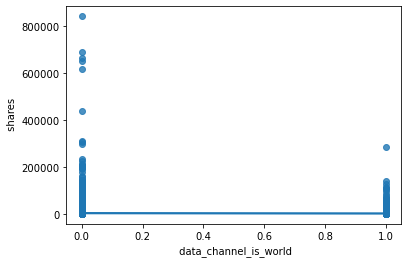

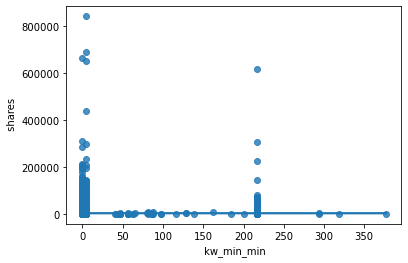

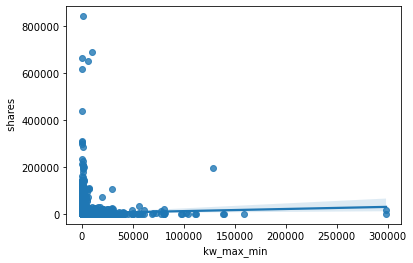

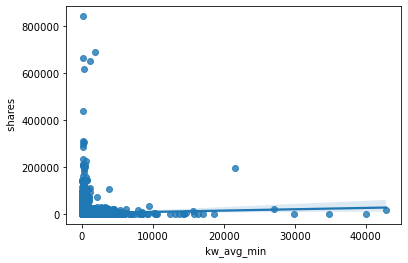

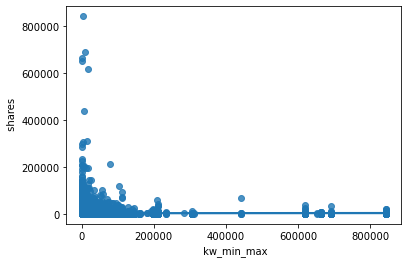

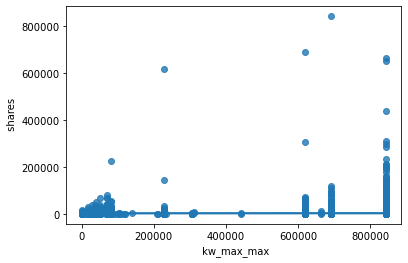

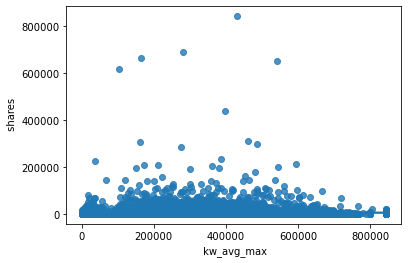

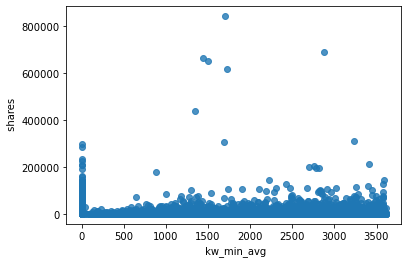

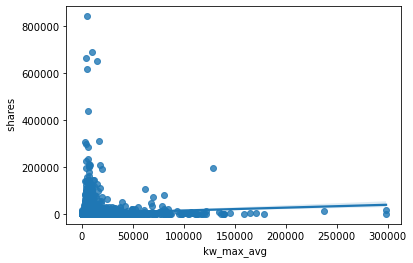

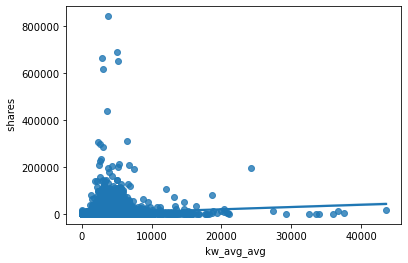

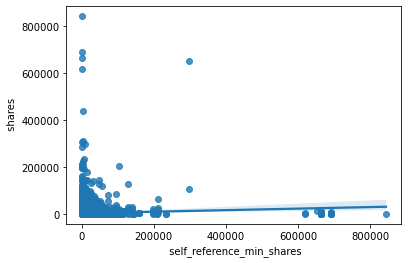

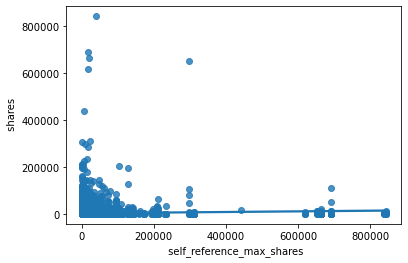

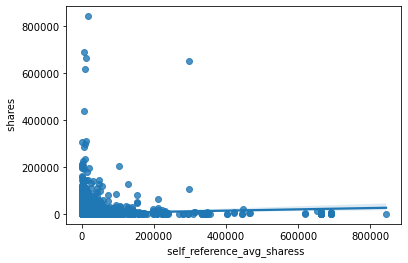

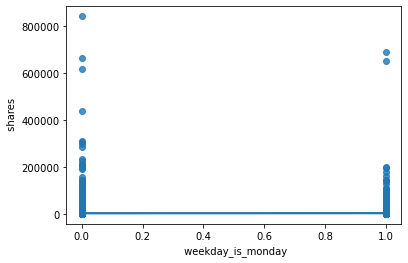

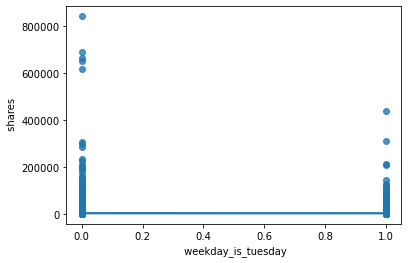

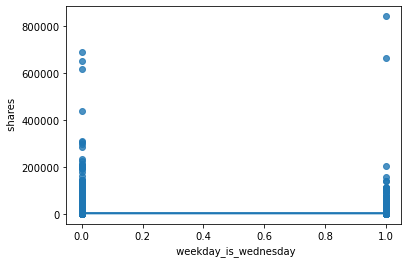

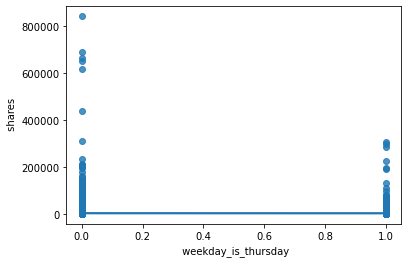

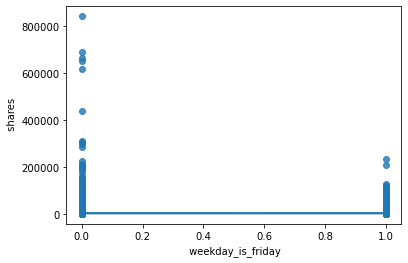

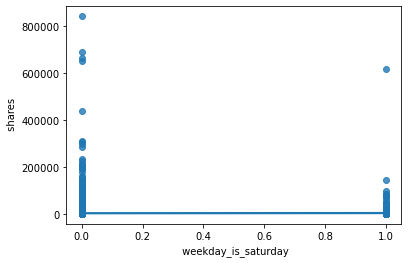

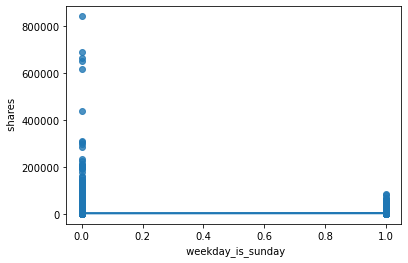

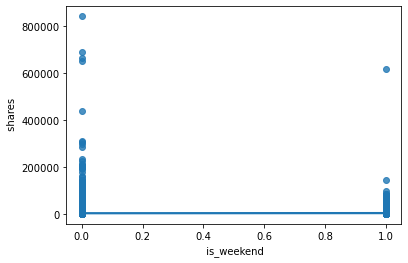

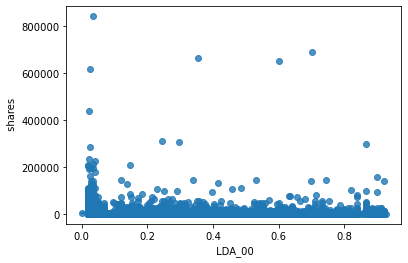

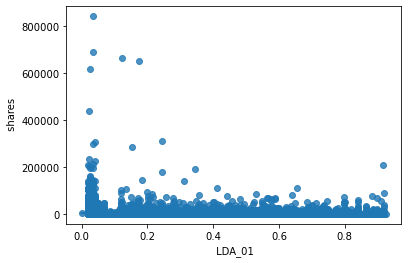

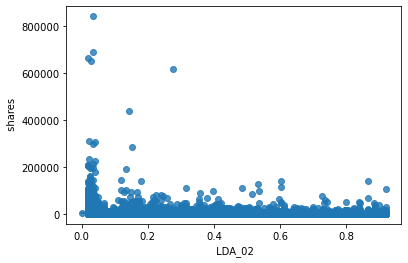

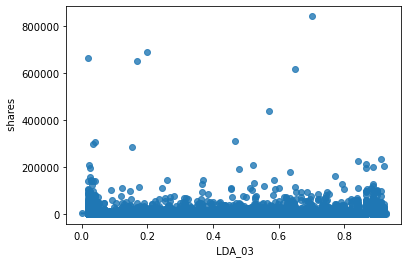

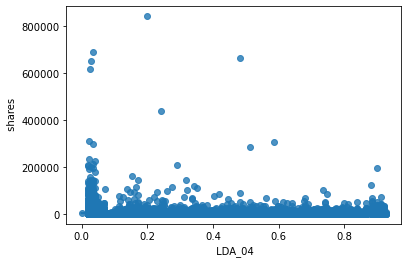

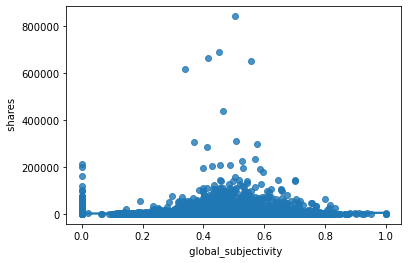

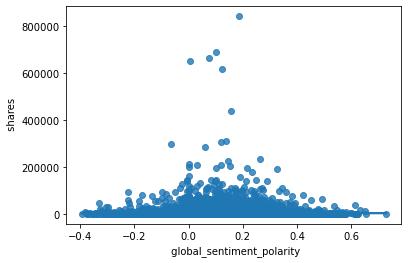

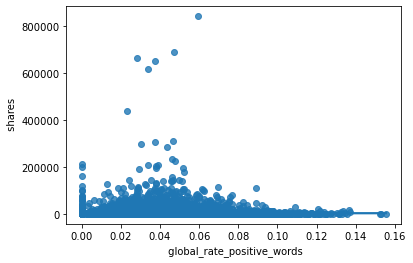

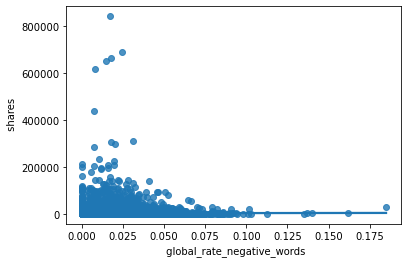

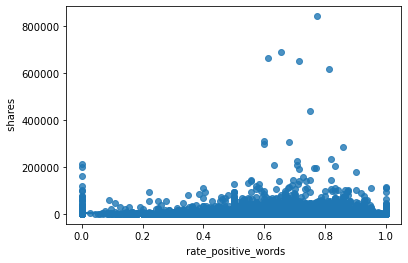

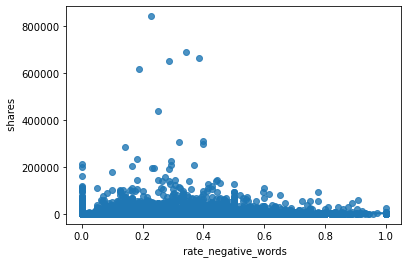

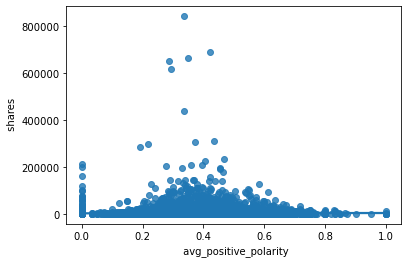

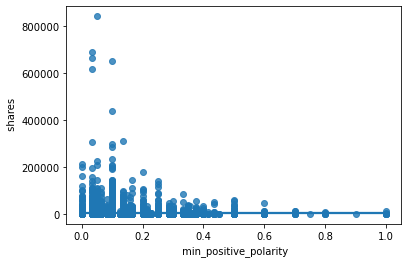

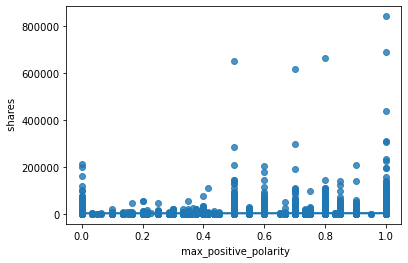

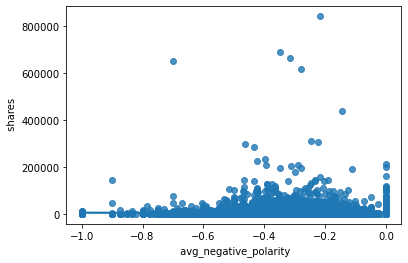

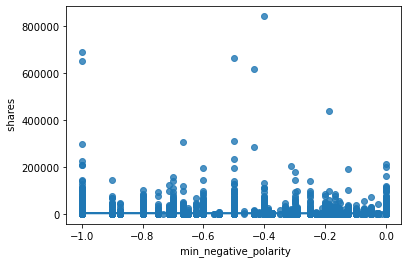

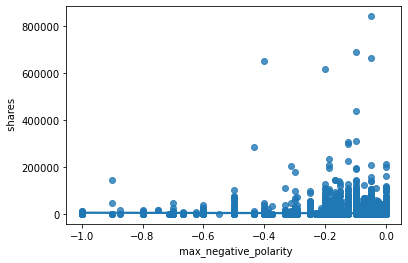

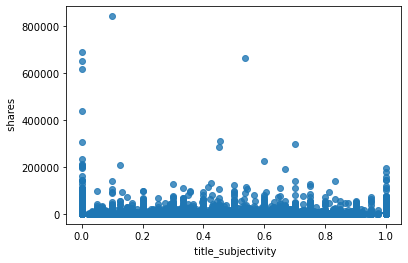

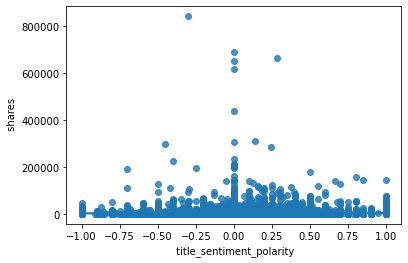

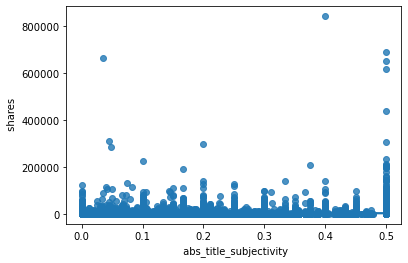

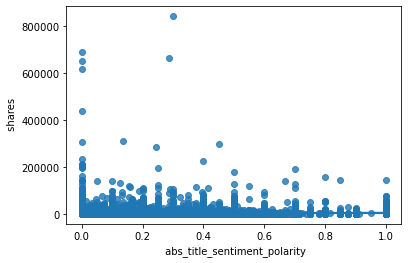

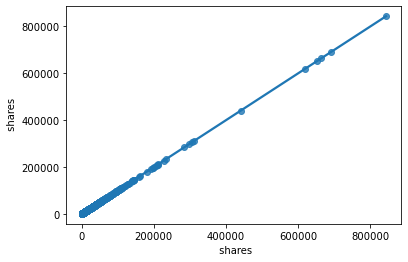

In [23]:
# Visualizing all predictors vs. response variable of shares (by Daniel He)
for x in cleaned:
    sns.regplot(x=x, y= ' shares', data=cleaned)
    plt.show()

## Developing the model: Hyperparameter tuning

### Adaboost, LightGBM, and Catboost
*By Daniel He*

#### 1) Adaboost

In [26]:
# Adaboost base model
ada_base = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(random_state = 1),
                           random_state = 1)
ada_base.fit(X_train_scaled, y_train)

ada_base_pred = ada_base.predict(X_test_scaled)
print('Accuracy:', accuracy_score(y_test, ada_base_pred))
print('Precision:', precision_score(y_test, ada_base_pred))

Accuracy: 0.6622524908563501
Precision: 0.6587039390088946


In [28]:
model = AdaBoostClassifier(random_state=1)
grid = dict()
grid['n_estimators'] = [10, 50, 100,200,500, 1000]
grid['learning_rate'] = [0.001, 0.01,0.1, 0.5, 1.0]
grid['base_estimator'] = [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=10), DecisionTreeClassifier(max_depth=15),DecisionTreeClassifier(max_depth=20)]

# define the evaluation procedure
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, 
                          verbose = True)
# execute the grid search
grid_result = grid_search.fit(X_train_scaled, y_train)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 2 folds for each of 120 candidates, totalling 240 fits
Best: 0.754974 using {'base_estimator': DecisionTreeClassifier(max_depth=1), 'learning_rate': 0.1, 'n_estimators': 1000}


In [29]:
ada_model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10), learning_rate=0.01, random_state = 1,
                         n_estimators=100).fit(X_train_scaled, y_train)
ada_pred = ada_model.predict(X_test_scaled)
print('Accuracy:', accuracy_score(y_test, ada_pred))
print('Precision:', precision_score(y_test, ada_pred))

Accuracy: 0.7442300416193719
Precision: 0.7239915074309978


In [20]:
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
threshold_vals = np.arange(0,1.01,0.01)
accuracy_iter = []
precision_iter = []

ada_model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=9), learning_rate=0.001, random_state = 1,
                         n_estimators=240)

predicted_probability = cross_val_predict(ada_model, 
                                    X_train_scaled, y_train, cv = 2, method = 'predict_proba')

for threshold_prob in threshold_vals:
        predicted_class = predicted_probability[:,1] > threshold_prob
        predicted_class = predicted_class.astype(int)
        
        accuracy = accuracy_score(y_train, predicted_class)
        precision = precision_score(y_train, predicted_class)
        accuracy_iter.append(accuracy)
        precision_iter.append(precision)

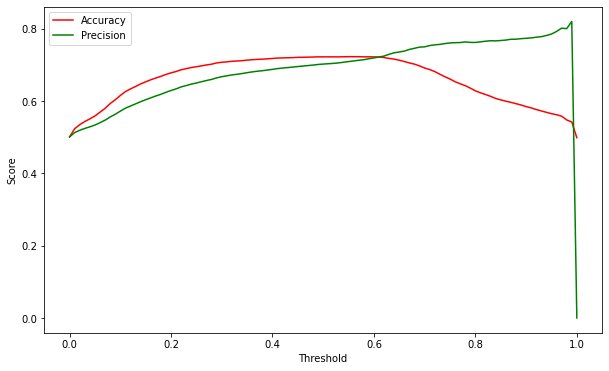

In [21]:
plt.figure(figsize=(10, 6));
plt.plot(threshold_vals, accuracy_iter, "r-", label = 'Accuracy');
plt.plot(threshold_vals, precision_iter, "g-", label = 'Precision');
plt.ylabel('Score');
plt.xlabel('Threshold');
plt.legend();

In [22]:
desired_threshold = 0.61

ada_model.fit(X_train_scaled, y_train)
ada_pred_prob = ada_model.predict_proba(X_train_scaled)[:,1] 

ada_pred = ada_pred_prob > desired_threshold
ada_pred = ada_pred.astype(int)

# Accuracy and precision

print("Train Accuracy: ", accuracy_score(y_train, ada_pred))  
print("Train Precision: ", precision_score(y_train, ada_pred))

Train Accuracy:  0.8306479583793158
Train Precision:  0.8337561841938348


In [23]:
ada_pred_prob_test = ada_model.predict_proba(X_test_scaled)[:,1] 

ada_pred_test = ada_pred_prob_test > desired_threshold
ada_pred_test = ada_pred_test.astype(int)

# Accuracy and precision

print("Test Accuracy: ", accuracy_score(y_test, ada_pred_test))  
print("Test Precision: ", precision_score(y_test, ada_pred_test))

Test Accuracy:  0.738176314793795
Test Precision:  0.7434885556432518


#### 2) LightGBM

In [26]:
from lightgbm import LGBMRegressor, LGBMClassifier
from catboost import CatBoostClassifier

# base model
lgbm_base = LGBMClassifier(random_state=1).fit(X_train_scaled, y_train)
lgbm_base_pred = lgbm_base.predict(X_test_scaled)

print('Accuracy:', accuracy_score(y_test, lgbm_base_pred))
print('Precision:', precision_score(y_test, lgbm_base_pred))

Accuracy: 0.7703367385546728
Precision: 0.7598716683119447


In [50]:
#K-fold cross validation to find optimal parameters for LightGBM regressor
start_time = time.time()
param_grid = {'max_depth': [4,6,8],
              'num_leaves': [20, 31, 40],
              'learning_rate': [0.01, 0.05, 0.1],
               'reg_lambda':[0, 10, 100],
                'n_estimators':[100, 500, 1000],
                'reg_alpha': [0, 10, 100],
                'subsample': [0.5, 0.75, 1.0]}

cv = KFold(n_splits=2,shuffle=True,random_state=1)
optimal_params = RandomizedSearchCV(estimator=LGBMClassifier(random_state=1),                                                       
                             param_distributions = param_grid, n_iter = 200,
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv)
optimal_params.fit(X_train_scaled,y_train)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation R-squared = ",optimal_params.best_score_)
print("Time taken = ", round((time.time()-start_time)/60), " minutes")

Fitting 2 folds for each of 200 candidates, totalling 400 fits
Optimal parameter values = {'subsample': 1.0, 'reg_lambda': 10, 'reg_alpha': 0, 'num_leaves': 31, 'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.01}
Optimal cross validation R-squared =  0.7643701765796785
Time taken =  5  minutes


In [27]:
lgbm_model = LGBMClassifier(random_state=1, subsample= 0.5, reg_lambda= 10, reg_alpha= 10, num_leaves= 40, n_estimators= 2000, max_depth= 8, learning_rate= 0.01, colsample_bytree = 0.75).fit(X_train_scaled, y_train)
lgbm_pred = lgbm_model.predict(X_test_scaled)

print('Accuracy:', accuracy_score(y_test, lgbm_pred))
print('Precision:', precision_score(y_test, lgbm_pred))

Accuracy: 0.7700844999369404
Precision: 0.7619521912350598


In [28]:
threshold_vals = np.arange(0,1.01,0.01)
accuracy_iter = []
precision_iter = []

predicted_probability = cross_val_predict(lgbm_model, 
                                    X_train_scaled, y_train, cv = 2, method = 'predict_proba')

for threshold_prob in threshold_vals:
        predicted_class = predicted_probability[:,1] > threshold_prob
        predicted_class = predicted_class.astype(int)
        
        accuracy = accuracy_score(y_train, predicted_class)
        precision = precision_score(y_train, predicted_class)
        accuracy_iter.append(accuracy)
        precision_iter.append(precision)

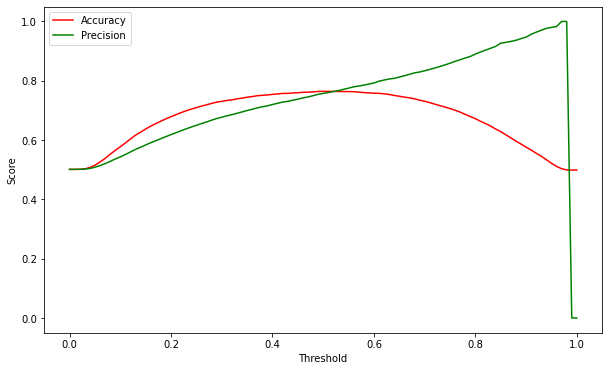

In [29]:
plt.figure(figsize=(10, 6));
plt.plot(threshold_vals, accuracy_iter, "r-", label = 'Accuracy');
plt.plot(threshold_vals, precision_iter, "g-", label = 'Precision');
plt.ylabel('Score');
plt.xlabel('Threshold');
plt.legend();

In [30]:
desired_threshold = 0.56

lgbm_model.fit(X_train_scaled, y_train)
lgbm_pred_prob = lgbm_model.predict_proba(X_train_scaled)[:,1] 

lgbm_pred = lgbm_pred_prob > desired_threshold
lgbm_pred = lgbm_pred.astype(int)

# Accuracy and precision

print("Train Accuracy: ", accuracy_score(y_train, lgbm_pred))  
print("Train Precision: ", precision_score(y_train, lgbm_pred))

Train Accuracy:  0.8243102632823585
Train Precision:  0.8481149254737979


In [31]:
lgbm_pred_test = lgbm_model.predict_proba(X_test_scaled)[:,1] 

lgbm_pred_test = lgbm_pred_test > desired_threshold
lgbm_pred_test = lgbm_pred_test.astype(int)

# Accuracy and precision

print("Test Accuracy: ", accuracy_score(y_test, lgbm_pred_test))  
print("Test Precision: ", precision_score(y_test, lgbm_pred_test))

Test Accuracy:  0.7709673350990036
Test Precision:  0.786587021449905


#### 3) Catboost

In [32]:
# base model
cat_base = CatBoostClassifier(random_state=1, verbose = False).fit(X_train_scaled, y_train)
cat_base_pred = cat_base.predict(X_test_scaled)

print('Accuracy:', accuracy_score(y_test, cat_base_pred))
print('Precision:', precision_score(y_test, cat_base_pred))

Accuracy: 0.7710934544078698
Precision: 0.7624254473161034


In [33]:
threshold_vals = np.arange(0,1.01,0.01)
accuracy_iter = []
precision_iter = []

cat_model = CatBoostClassifier(random_state=1, verbose = False)

predicted_probability = cross_val_predict(cat_model, 
                                    X_train_scaled, y_train, cv = 2, method = 'predict_proba')

for threshold_prob in threshold_vals:
        predicted_class = predicted_probability[:,1] > threshold_prob
        predicted_class = predicted_class.astype(int)
        
        accuracy = accuracy_score(y_train, predicted_class)
        precision = precision_score(y_train, predicted_class)
        accuracy_iter.append(accuracy)
        precision_iter.append(precision)

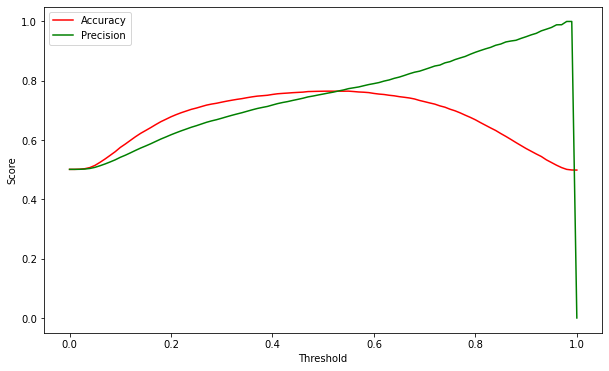

In [34]:
plt.figure(figsize=(10, 6));
plt.plot(threshold_vals, accuracy_iter, "r-", label = 'Accuracy');
plt.plot(threshold_vals, precision_iter, "g-", label = 'Precision');
plt.ylabel('Score');
plt.xlabel('Threshold');
plt.legend();

In [35]:
desired_threshold = 0.52

cat_model.fit(X_train_scaled, y_train)
cat_pred_prob = cat_model.predict_proba(X_train_scaled)[:,1] 

cat_pred = cat_pred_prob > desired_threshold
cat_pred = cat_pred.astype(int)

# Accuracy and precision

print("Train Accuracy: ", accuracy_score(y_train, cat_pred))  
print("Train Precision: ", precision_score(y_train, cat_pred))

Train Accuracy:  0.8365442219769825
Train Precision:  0.8420514785718848


In [36]:
cat_pred_prob_test = cat_model.predict_proba(X_test_scaled)[:,1] 

cat_pred_test = cat_pred_prob_test > desired_threshold
cat_pred_test = cat_pred_test.astype(int)

# Accuracy and precision

print("Test Accuracy: ", accuracy_score(y_test, cat_pred_test))  
print("Test Precision: ", precision_score(y_test, cat_pred_test))

Test Accuracy:  0.7717240509522008
Test Precision:  0.7709239825953417


### Random Forest, Gradient Boosting, and XGBoost
*By Sarah Hsu*

#### 1) Random Forest

In [84]:
base_model = RandomForestClassifier(random_state = 1, max_features = 'sqrt',
                               n_jobs = -1)
base_model.fit(X_train_scaled, y_train)

y_pred = base_model.predict(X_test_scaled)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))

Accuracy: 0.7598688359187792
Precision: 0.7414657436142278


In [ ]:
model = RandomForestClassifier(random_state = 1, max_features = 'sqrt')

params = {'n_estimators': [500, 750, 1000],
          'max_depth':[25, 30, 35],
         'min_samples_split': [3, 5, 6, 7]}

grid_search = GridSearchCV(estimator = model, param_grid = params, verbose = 1,
                           n_jobs = -1, cv = 2, scoring = ['accuracy', 'precision'],
                          refit = 'precision')
grid_result = grid_search.fit(X_train_scaled, y_train)

print("Best params:", grid_result.best_params_)

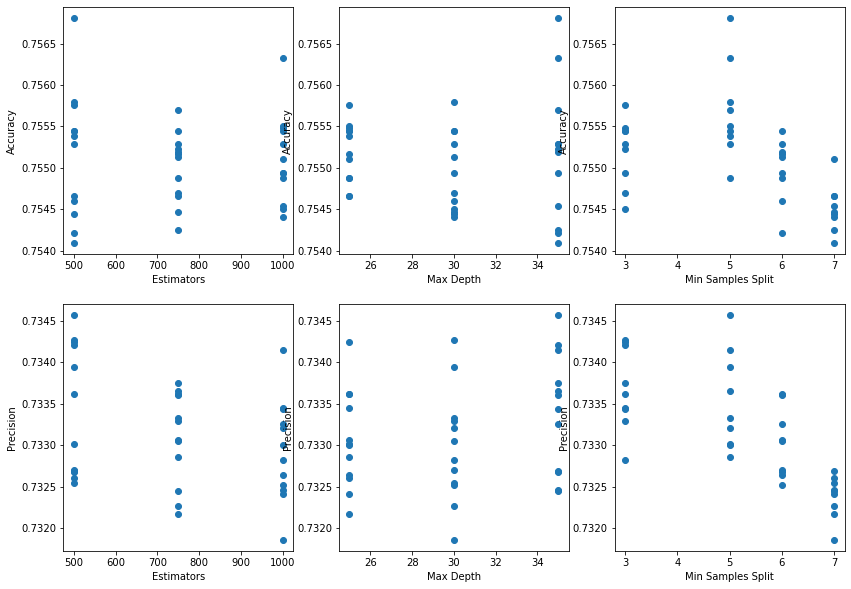

In [86]:
cv_results = pd.DataFrame(grid_result.cv_results_)

fig, axes = plt.subplots(2,3,figsize=(14,10));
plt.subplots_adjust(wspace=0.2);
axes[0,0].plot(cv_results.param_n_estimators, cv_results.mean_test_accuracy, 'o');
axes[0,0].set_xlabel('Estimators');
axes[0,0].set_ylabel('Accuracy');
axes[0,1].plot(cv_results.param_max_depth, cv_results.mean_test_accuracy, 'o');
axes[0,1].set_xlabel('Max Depth');
axes[0,1].set_ylabel('Accuracy');
axes[0,2].plot(cv_results.param_min_samples_split, cv_results.mean_test_accuracy, 'o');
axes[0,2].set_xlabel('Min Samples Split');
axes[0,2].set_ylabel('Accuracy');

axes[1,0].plot(cv_results.param_n_estimators, cv_results.mean_test_precision, 'o');
axes[1,0].set_xlabel('Estimators');
axes[1,0].set_ylabel('Precision');
axes[1,1].plot(cv_results.param_max_depth, cv_results.mean_test_precision, 'o');
axes[1,1].set_xlabel('Max Depth');
axes[1,1].set_ylabel('Precision');
axes[1,2].plot(cv_results.param_min_samples_split, cv_results.mean_test_precision, 'o');
axes[1,2].set_xlabel('Min Samples Split');
axes[1,2].set_ylabel('Precision');

In [37]:
threshold_vals = np.arange(0,1,0.01)
accuracy_iter = []
precision_iter = []

rf_model = RandomForestClassifier(max_features = 'sqrt', max_depth = 35, min_samples_split = 6,
                                 n_estimators = 750, random_state = 1)

predicted_probability = cross_val_predict(rf_model, 
                                    X_train, y_train, cv = 5, method = 'predict_proba')

for threshold_prob in threshold_vals:
        predicted_class = predicted_probability[:,1] > threshold_prob
        predicted_class = predicted_class.astype(int)
        
        accuracy = accuracy_score(y_train, predicted_class)
        precision = precision_score(y_train, predicted_class)
        accuracy_iter.append(accuracy)
        precision_iter.append(precision)

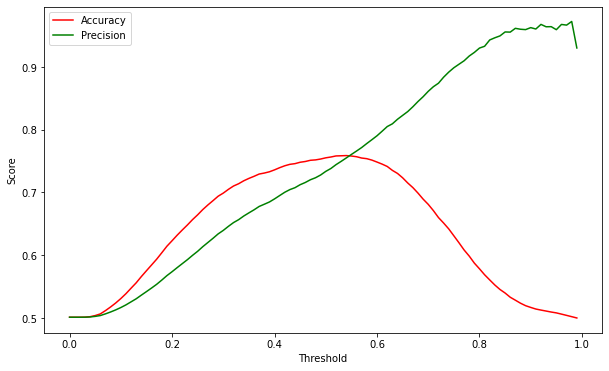

In [88]:
plt.figure(figsize=(10, 6));
plt.plot(threshold_vals, accuracy_iter, "r-", label = 'Accuracy');
plt.plot(threshold_vals, precision_iter, "g-", label = 'Precision');
plt.ylabel('Score');
plt.xlabel('Threshold');
plt.legend();

In [89]:
scores_RF = pd.DataFrame(columns = ['Threshold', 'Accuracy', 'Precision'])
scores_RF['Threshold'] = threshold_vals
scores_RF['Accuracy'] = accuracy_iter
scores_RF['Precision'] = precision_iter

scores_RF[(scores_RF.Accuracy >= 0.75) & (scores_RF.Precision >= 0.7)]

,Threshold,Accuracy,Precision
47,0.47,0.751253,0.720235
48,0.48,0.751884,0.723441
49,0.49,0.753271,0.727837
50,0.50,0.755195,0.733582
51,0.51,0.756487,0.738195
52,0.52,0.758190,0.744298
53,0.53,0.758442,0.749515
54,0.54,0.758758,0.754980
55,0.55,0.758064,0.760553
56,0.56,0.756960,0.765967


In [90]:
desired_threshold = 0.61

rf_model.fit(X_train_scaled, y_train)
y_pred_prob = rf_model.predict_proba(X_train_scaled)[:,1] 

y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

# Accuracy and precision

print("Train Accuracy: ", accuracy_score(y_train, y_pred))  
print("Train Precision: ", precision_score(y_train, y_pred))

Train Accuracy:  0.9769509695727574
Train Precision:  0.9998681434599156


In [91]:
y_pred_prob = rf_model.predict_proba(X_test_scaled)[:,1] 

y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

# Accuracy and precision

print("Test Accuracy: ", accuracy_score(y_test, y_pred))  
print("Test Precision: ", precision_score(y_test, y_pred))

Test Accuracy:  0.7531845125488712
Test Precision:  0.8053316800991941


#### 2) Gradient Boosting

In [94]:
from sklearn.linear_model import LogisticRegression
from patsy import dmatrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb

base_model = GradientBoostingClassifier(random_state = 1) 
base_model.fit(X_train_scaled, y_train)

y_pred = base_model.predict(X_test_scaled)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))

Accuracy: 0.7611300290074411
Precision: 0.7433564759396696


In [ ]:
model = GradientBoostingClassifier(n_iter_no_change = 10, random_state = 1)

params = {'n_estimators': [500, 750, 1000],
          'learning_rate':[0.01, 0.05, 0.1],
          'max_depth':[8, 10, 12],
         'min_samples_split': [2, 5, 8],
         'subsample':[0.5, 0.6, 0.7, 0.8]}

cv = StratifiedKFold(n_splits = 5,shuffle=True,random_state = 1)

grid_search = RandomizedSearchCV(estimator = model, param_distributions = params, verbose = 1,
                           n_iter = 200, n_jobs = -1, cv = cv, scoring = ['accuracy', 'precision'],
                          refit = 'precision', random_state = 1)
grid_result = grid_search.fit(X_train_scaled, y_train)

print("Best params:", grid_result.best_params_)

In [38]:
threshold_vals = np.arange(0,1.01,0.01)
accuracy_iter = []
precision_iter = []

gradient_model = GradientBoostingClassifier(subsample = 0.75, n_estimators = 750, min_samples_split = 5,
                                            max_depth = 10, learning_rate = 0.01,
                                   n_iter_no_change = 10, random_state = 1)

predicted_probability = cross_val_predict(gradient_model, 
                                    X_train, y_train, cv = 5, method = 'predict_proba')

for threshold_prob in threshold_vals:
        predicted_class = predicted_probability[:,1] > threshold_prob
        predicted_class = predicted_class.astype(int)
        
        accuracy = accuracy_score(y_train, predicted_class)
        precision = precision_score(y_train, predicted_class)
        accuracy_iter.append(accuracy)
        precision_iter.append(precision)

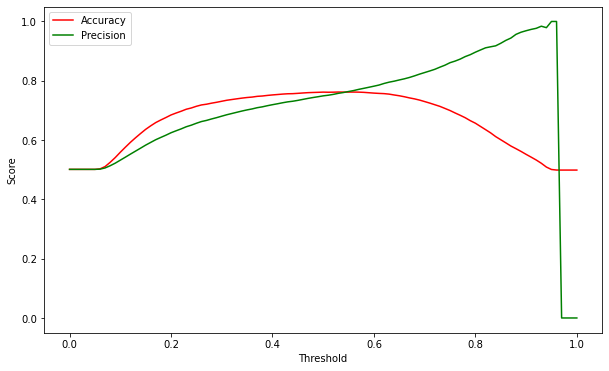

In [103]:
plt.figure(figsize=(10, 6));
plt.plot(threshold_vals, accuracy_iter, "r-", label = 'Accuracy');
plt.plot(threshold_vals, precision_iter, "g-", label = 'Precision');
plt.ylabel('Score');
plt.xlabel('Threshold');
plt.legend();

In [104]:
scores_grad = pd.DataFrame(columns = ['Threshold', 'Accuracy', 'Precision'])
scores_grad['Threshold'] = threshold_vals
scores_grad['Accuracy'] = accuracy_iter
scores_grad['Precision'] = precision_iter

scores_grad[(scores_grad.Accuracy >= 0.75) & (scores_grad.Precision >= 0.75)]

,Threshold,Accuracy,Precision
51,0.51,0.761312,0.751252
52,0.52,0.761532,0.754086
53,0.53,0.762005,0.757671
54,0.54,0.761816,0.760380
55,0.55,0.761848,0.763787
56,0.56,0.761911,0.766957
57,0.57,0.761627,0.770986
58,0.58,0.760933,0.774483
59,0.59,0.759641,0.778069
60,0.60,0.758379,0.781725


In [105]:
desired_threshold = 0.58

gradient_model.fit(X_train_scaled, y_train)
y_pred_prob = gradient_model.predict_proba(X_train_scaled)[:,1] 

y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

# Accuracy and precision

print("Train Accuracy: ", accuracy_score(y_train, y_pred))  
print("Train Precision: ", precision_score(y_train, y_pred))

Train Accuracy:  0.9265016553681223
Train Precision:  0.9560247444862829


In [106]:
y_pred_prob = gradient_model.predict_proba(X_test_scaled)[:,1] 

y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

# Accuracy and precision

print("Test Accuracy: ", accuracy_score(y_test, y_pred))  
print("Test Precision: ", precision_score(y_test, y_pred))

Test Accuracy:  0.7724807668053979
Test Precision:  0.789315889888253


#### 3) XGBoost

In [107]:
base_model = xgb.XGBClassifier(random_state = 1, objective = 'binary:logistic',
                                                         scale_pos_weight = 1)
base_model.fit(X_train_scaled, y_train)

y_pred = base_model.predict(X_test_scaled)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))

Accuracy: 0.7602471938453778
Precision: 0.7554210791729703


In [ ]:
param_grid = {'n_estimators':[500, 1000, 2000],
         'learning_rate': [0.005, 0.01, 0.05],
         'max_depth': [8, 10, 12],
         'subsample': [0.6, 0.8, 1.0],
         'gamma': [0, 10],
         'reg_lambda':[0, 1, 10]}

cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 1)


grid_search = RandomizedSearchCV(estimator = xgb.XGBClassifier(random_state = 1, objective = 'binary:logistic',
                                                         scale_pos_weight = 1),                                                       
                             param_distributions = param_grid, scoring = ['accuracy', 'precision'], 
                                 refit = 'precision', n_iter = 150,
                                 verbose = 1, n_jobs = 8, cv = cv)

grid_result = grid_search.fit(X_train_scaled,y_train)

print("Optimal parameters: ", grid_search.best_params_)

In [40]:
import xgboost as xgb

threshold_vals = np.arange(0,1.01,0.01)
accuracy_iter = []
precision_iter = []

xgb_model = xgb.XGBClassifier(random_state = 1, objective = 'binary:logistic', scale_pos_weight = 1,
                             subsample = 0.8, reg_lambda = 10, n_estimators = 2000, 
                              max_depth = 10, learning_rate = 0.01, gamma = 0)

predicted_probability = cross_val_predict(xgb_model, 
                                    X_train, y_train, cv = 5, method = 'predict_proba')

for threshold_prob in threshold_vals:
        predicted_class = predicted_probability[:,1] > threshold_prob
        predicted_class = predicted_class.astype(int)
        
        accuracy = accuracy_score(y_train, predicted_class)
        precision = precision_score(y_train, predicted_class)
        accuracy_iter.append(accuracy)
        precision_iter.append(precision)

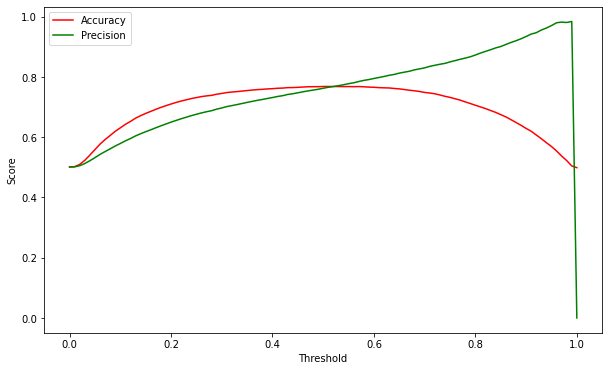

In [110]:
plt.figure(figsize=(10, 6));
plt.plot(threshold_vals, accuracy_iter, "r-", label = 'Accuracy');
plt.plot(threshold_vals, precision_iter, "g-", label = 'Precision');
plt.ylabel('Score');
plt.xlabel('Threshold');
plt.legend();

In [111]:
scores_grad = pd.DataFrame(columns = ['Threshold', 'Accuracy', 'Precision'])
scores_grad['Threshold'] = threshold_vals
scores_grad['Accuracy'] = accuracy_iter
scores_grad['Precision'] = precision_iter

scores_grad[(scores_grad.Accuracy >= 0.75) & (scores_grad.Precision >= 0.75)]

,Threshold,Accuracy,Precision
46,0.46,0.766514,0.750650
47,0.47,0.767397,0.753602
48,0.48,0.767618,0.756360
49,0.49,0.767649,0.758991
50,0.50,0.768280,0.762469
51,0.51,0.768343,0.765631
52,0.52,0.768248,0.768289
53,0.53,0.768059,0.770890
54,0.54,0.767902,0.774088
55,0.55,0.768091,0.777669


In [112]:
desired_threshold = 0.65

xgb_model.fit(X_train_scaled, y_train)
y_pred_prob = xgb_model.predict_proba(X_train_scaled)[:,1] 

y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

# Accuracy and precision

print("Train Accuracy: ", accuracy_score(y_train, y_pred))  
print("Train Precision: ", precision_score(y_train, y_pred))

Train Accuracy:  0.9708970518682012
Train Precision:  0.9986013054482483


In [113]:
y_pred_prob = xgb_model.predict_proba(X_test_scaled)[:,1] 

y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

# Accuracy and precision

print("Test Accuracy: ", accuracy_score(y_test, y_pred))  
print("Test Precision: ", precision_score(y_test, y_pred))

Test Accuracy:  0.7642830117290957
Test Precision:  0.8207605985037406


### Bagged trees, Ridge/Lasso
*By Gemily Wang*

Results on Github under <a href="https://github.com/danielhe-nu/STAT-303-3-Project/blob/main/classification_models_ridge_lasso%2C_bagging.ipynb">link</a> , but base code is here: 

#### 1) Lasso

In [ ]:
#BASE
model_lasso_base = LogisticRegression(penalty='l1', solver='liblinear').fit(X_train_sca, y_train)
lasso_accuracy = model_lasso_base.score(X_test_sca, y_test)
print("Base lasso model accuracy: ", lasso_accuracy)

y_pred = model_lasso_base.predict(X_test_scaled)
print("Base lasso model precision: ", precision_score(y_test, y_pred))

In [ ]:
#BEST
model_test = LogisticRegression(penalty='l1', solver='liblinear', tol=1e-05).fit(X_train_sca, y_train)
print("Accuracy = ", model_test.score(X_test_scaled, y_test))
y_pred = model_test.predict(X_test_scaled)
print("Precision: ", precision_score(y_test, y_pred))

In [ ]:
param_grid = {'C': [0.01, 0.1, 1.0, 10.0],
              'penalty': ['l1'],
              'solver': ['liblinear', 'saga']
              }

model = LogisticRegression()

grid_search = GridSearchCV(model, param_grid, cv=5).fit(X_train_sca, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_lasso_model = grid_search.best_estimator_

# Evaluate the best model on the test set
best_lasso_model.fit(X_train_scaled, y_train)
best_accuracy = best_lasso_model.score(X_test_scaled, y_test)

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

In [ ]:
param_grid = {'C': [0.01, 0.1, 1.0, 10.0],
              'penalty': ['l1'],
              'solver': ['liblinear', 'saga'],
              'tol': [1e-5, 1e-4, 1e-3]
              }

model = LogisticRegression()

grid_search = GridSearchCV(model, param_grid, cv=5).fit(X_train_sca, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_lasso_model = grid_search.best_estimator_

# Evaluate the best model on the test set
best_accuracy = best_lasso_model.score(X_test_scaled, y_test)

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

In [ ]:
param_grid = {'C': [0.01, 0.1, 0.5, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 2.0, 5.0, 10.0],
              'penalty': ['l1'],
              'solver': ['liblinear'],
              'tol': [1e-5]
              }

model = LogisticRegression()

grid_search = GridSearchCV(model, param_grid, cv=5).fit(X_train_sca, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_lasso_model = grid_search.best_estimator_

# Evaluate the best model on the test set
best_accuracy = best_lasso_model.score(X_test_scaled, y_test)

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

#### 2) Ridge

In [ ]:
#BASE
model_ridge_base = LogisticRegression(penalty='l2').fit(X_train_scaled, y_train)
ridge_accuracy = model_ridge_base.score(X_test_scaled, y_test)
print("Base ridge model accuracy: ", ridge_accuracy)

y_pred = model_ridge_base.predict(X_test_scaled)
print("Precision: ", precision_score(y_test, y_pred))

In [ ]:
#BEST
model_ridge = LogisticRegression(penalty='l2', solver = 'newton-cg', C = 10).fit(X_train_sca, y_train)
ridge_accuracy = model_ridge.score(X_test_sca, y_test)
print("Accuracy: ", ridge_accuracy)

y_pred = model_ridge.predict(X_test_sca)
print("Precision: ", precision_score(y_test, y_pred))

In [ ]:
param_grid = {'C': [0.01, 0.1, 1.0, 10],
              'penalty': ['l2'],
              'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']
              }

model = LogisticRegression()

grid_search = GridSearchCV(model, param_grid, cv=5).fit(X_train_sca, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_ridge_model = grid_search.best_estimator_

# Evaluate the best model on the test set
best_ridge_model.fit(X_train_sca, y_train)
best_accuracy = best_ridge_model.score(X_test_sca, y_test)

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

In [ ]:
param_grid = {'C': [1.0, 10, 100, 1000],
              'penalty': ['l2'],
              'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']
              }

model = LogisticRegression()

grid_search = GridSearchCV(model, param_grid, cv=5).fit(X_train_sca, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_ridge_model = grid_search.best_estimator_

# Evaluate the best model on the test set
best_ridge_model.fit(X_train_sca, y_train)
best_accuracy = best_ridge_model.score(X_test_sca, y_test)

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

In [ ]:
param_grid = {'C': [1, 4, 7, 10, 40, 70, 100],
              'penalty': ['l2'],
              'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']
              }

model = LogisticRegression()

grid_search = GridSearchCV(model, param_grid, cv=5).fit(X_train_sca, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_ridge_model = grid_search.best_estimator_

# Evaluate the best model on the test set
best_ridge_model.fit(X_train_sca, y_train)
best_accuracy = best_ridge_model.score(X_test_sca, y_test)

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

In [ ]:
param_grid = {'C': [1, 4, 7, 10, 40, 70, 100],
              'penalty': ['l2'],
              'solver': ['saga'],
              'tol': [1e-5, 1e-4, 1e-3, 1e-2]
              }

model = LogisticRegression()

grid_search = GridSearchCV(model, param_grid, cv=5).fit(X_train_sca, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_ridge_model = grid_search.best_estimator_

# Evaluate the best model on the test set
best_ridge_model.fit(X_train_sca, y_train)
best_accuracy = best_ridge_model.score(X_test_sca, y_test)

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

#### 3) Bagged

In [ ]:
model_bag_base = BaggingClassifier(DecisionTreeClassifier(), random_state = 1).fit(X_train_scaled, y_train)
bag_accuracy = model_bag_base.score(X_test_scaled, y_test)
print("Bagging base model accuracy = ", bag_accuracy)

y_pred = model_bag_base.predict(X_test_scaled)
print("Precision: ", precision_score(y_test, y_pred))

In [ ]:
params = {'n_estimators': [1000, 1500],
          'max_samples': [0.8, 1.0],
          'max_features': [0.8, 1.0],
          'bootstrap': [True, False],
          'bootstrap_features': [True, False],
          }

# Perform a grid search to find the best hyperparameters
cv = KFold(n_splits=2,shuffle=True,random_state=1)
grid_search = GridSearchCV(BaggingClassifier(base_estimator = DecisionTreeClassifier(random_state = 1),
                                                       random_state=1, n_jobs=-1), 
                                      param_grid=params, cv=cv, n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

In [ ]:
params = {'n_estimators': [100, 500, 1000],
          'max_samples': [0.1, 0.5, 1.0],
          'max_features': [0.1, 0.5, 1.0],
          'bootstrap': [True, False],
          'bootstrap_features': [True, False],
          }

# Get the best model
print("best params: ", grid_search.best_params_)
model_bag = grid_search.best_estimator_

# Evaluate the model on the test set
model_bag.fit(X_train_scaled, y_train)
y_pred = model_bag.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy = ", accuracy)

In [ ]:
params = {'n_estimators': [1000, 1500],
          'max_samples': [0.8, 1.0],
          'max_features': [0.8, 1.0],
          'bootstrap': [True, False],
          'bootstrap_features': [True, False],
          }

# Get the best model
print("best params: ", grid_search.best_params_)
model_bag = grid_search.best_estimator_

# Evaluate the model on the test set
model_bag.fit(X_train_sca, y_train)
y_pred = model_bag.predict(X_test_sca)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy = ", accuracy)

### Decision Tree
*By Anika Kaura*

Results on Github under <a href="https://github.com/danielhe-nu/STAT-303-3-Project/blob/main/Models%20Anika.ipynb">link</a> , but base code is here: 

In [ ]:
model = DecisionTreeClassifier(random_state=1).fit(X_train,y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Precision:", precision)

In [ ]:
parameters = {'max_features': [20,30,40,50],
              'max_depth': [5,10,15,20],
              'max_leaf_nodes': [5,10,20,30,40,50]}

cv = KFold(n_splits = 5, shuffle=True, random_state=45)

grid = GridSearchCV(DecisionTreeClassifier(random_state=1), parameters, n_jobs=-1, verbose=1, cv=cv,
                    scoring='neg_mean_absolute_error')

grid.fit(X_train_scaled, y_train)
print(grid.best_score_, grid.best_params_)

In [ ]:
model = DecisionTreeClassifier(random_state=1,max_depth=10,max_features=30,max_leaf_nodes=20).fit(X_train_scaled,y_train)
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Precision:", precision)

In [ ]:
thresholds = np.arange(0.01, 2, 0.1)
accuracy_scores = []
precision_scores = []

kf = KFold(n_splits=5) 

for threshold in thresholds:
    model = model
    y_pred_probs = cross_val_predict(model, X, y, cv=kf, method='predict_proba')
    y_pred = np.where(y_pred_probs[:, 1] >= threshold, 1, 0)
    accuracy_scores.append(accuracy_score(y, y_pred))
    precision_scores.append(precision_score(y, y_pred))

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(thresholds, accuracy_scores, label='Accuracy')
plt.plot(thresholds, precision_scores, label='Precision')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Cross-Validated Accuracy and Precision')
plt.legend()
plt.show()

In [ ]:
threshold = 0.50

model = model
y_pred_probs_test = model.predict_proba(X_test)
y_pred_test = np.where(y_pred_probs_test[:, 1] >= threshold, 1, 0)

accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)

print("Test Accuracy:", accuracy_test)
print("Test Precision:", precision_test)

## Model Ensemble 

### Voting ensemble
*By Daniel He*

In [41]:
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier

# Hard Voting Voting
ensemble_model = VotingClassifier(estimators=[('xgb',xgb_model),('grad',gradient_model),('rf',rf_model), ('ada', ada_model), ('cat',cat_base), ('lgbm', lgbm_base)])
ensemble_model.fit(X_train_scaled,y_train)
ensemble_model.score(X_test_scaled, y_test)

0.773237482658595

In [42]:
def compute_feature_importance(ensemble_model, weights):
    """ Function to compute feature importance of Voting Classifier """
    
    feature_importance = dict()
    for est in ensemble_model.estimators_:
        feature_importance[str(est)] = est.feature_importances_
    
    fe_scores = [0]*len(list(feature_importance.values())[0])
    for idx, imp_score in enumerate(feature_importance.values()):
        imp_score_with_weight = imp_score*weights[idx]
        fe_scores = list(np.add(fe_scores, list(imp_score_with_weight)))
    return fe_scores
compute_feature_importance

<function __main__.compute_feature_importance(ensemble_model, weights)>

In [43]:
df = pd.DataFrame()
df['Feature'] = X_train.columns
df['Feature Importance'] = compute_feature_importance(ensemble_model, [1, 2, 3, 4, 5, 6])
df.sort_values('Feature Importance', ascending=False)

,Feature,Feature Importance
24,kw_max_avg,1398.040509
22,kw_avg_max,713.212814
25,kw_avg_avg,703.503668
26,self_reference_min_shares,684.462612
19,kw_avg_min,647.983337
38,LDA_01,593.684776
37,LDA_00,574.382991
2,n_unique_tokens,568.703243
4,n_non_stop_unique_tokens,544.588531
18,kw_max_min,543.530115


In [44]:
# Soft Voting

xgb_grad_rf_soft = VotingClassifier(estimators=[('xgb',xgb_model),('grad',gradient_model),('rf',rf_model), ('ada', ada_model), ('cat',cat_base), ('lgbm', lgbm_base)],
                                 voting='soft')
xgb_grad_rf_soft.fit(X_train_scaled,y_train)
xgb_grad_rf_soft.score(X_test_scaled, y_test)

0.770588977172405

### Stacking ensemble(s)
*By Daniel He*

In [ ]:
#Using Logistic regression as the meta model (final_estimator)
xgb_grad_rf_stack = StackingClassifier(estimators=[('xgb',xgb_model),('grad',gradient_model),('rf',rf_model), ('ada', ada_model), ('cat',cat_base), ('lgbm', lgbm_base)],
                                   final_estimator=LogisticRegression(random_state=1,max_iter=100),n_jobs=-1,
                                   cv = StratifiedKFold(n_splits=2,shuffle=True,random_state=1))
xgb_grad_rf_stack.fit(X_train_scaled,y_train)
xgb_grad_rf_stack.score(X_test_scaled, y_test)

### Ensemble of ensembled models

In [ ]:
ee_model = VotingClassifier(estimators=[('xgb',ensemble_model),('grad',xgb_grad_rf_soft),('rf',xgb_grad_rf_stack)])
ee_model.fit(X_train_scaled,y_train)
ee_model.score(X_test_scaled, y_test)

In [ ]:
df = pd.DataFrame()
df['Feature'] = X_train.columns
df['Feature Importance'] = compute_feature_importance(ee_model, [1, 2,3])
df.sort_values('Feature Importance', ascending=False)